# Visualize D4RL dataset

In [6]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.nn.utils.rnn import pad_sequence

from src.utils.data import parse_stacked_trajectories

seed = 0

In [2]:
hopper_obs_names = [
    "top-z", "top-angle", "thigh-angle", "leg-angle",
    "foot-angle", "top-x-v", "top-z-v", "top-angle-v",
    "thigh-angle-v", "leg-angle-v", "foot-angle-v"
]

In [4]:
# load data
# filename = "../data/d4rl/hopper-expert-v2.p"

with open("../data/d4rl/hopper-expert-v2.p", "rb") as f:
    expert_dataset = pickle.load(f)

with open("../data/d4rl/hopper-medium-expert-v2.p", "rb") as f:
    medium_expert_dataset = pickle.load(f)

print("keys:", expert_dataset.keys())

keys: dict_keys(['actions', 'infos/action_log_probs', 'infos/qpos', 'infos/qvel', 'metadata/algorithm', 'metadata/iteration', 'metadata/policy/fc0/bias', 'metadata/policy/fc0/weight', 'metadata/policy/fc1/bias', 'metadata/policy/fc1/weight', 'metadata/policy/last_fc/bias', 'metadata/policy/last_fc/weight', 'metadata/policy/last_fc_log_std/bias', 'metadata/policy/last_fc_log_std/weight', 'metadata/policy/nonlinearity', 'metadata/policy/output_distribution', 'next_observations', 'observations', 'rewards', 'terminals', 'timeouts'])


In [8]:
# compare dataset returns
expert_traj_dataset = parse_stacked_trajectories(
    obs=expert_dataset["observations"],
    act=expert_dataset["actions"],
    rwd=expert_dataset["rewards"],
    next_obs=expert_dataset["next_observations"],
    terminated=expert_dataset["terminals"],
    timeout=expert_dataset["timeouts"],
    max_eps=1000
)
medium_expert_traj_dataset = parse_stacked_trajectories(
    obs=medium_expert_dataset["observations"],
    act=medium_expert_dataset["actions"],
    rwd=medium_expert_dataset["rewards"],
    next_obs=medium_expert_dataset["next_observations"],
    terminated=medium_expert_dataset["terminals"],
    timeout=medium_expert_dataset["timeouts"],
    max_eps=1000
)

expert_returns = [np.sum(traj["rwd"]) for traj in expert_traj_dataset]
medium_expert_returns = [np.sum(traj["rwd"]) for traj in medium_expert_traj_dataset]

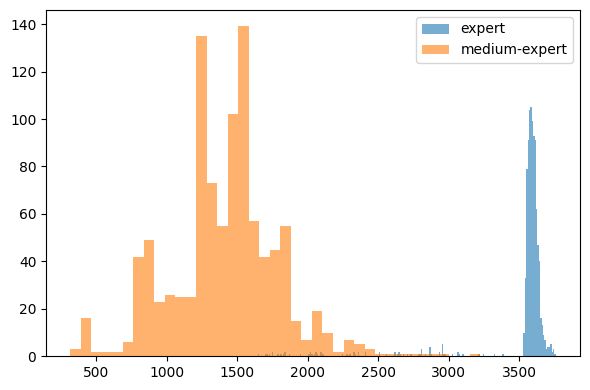

In [10]:
# plot expert and medium expert return distributions
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(expert_returns, bins="fd", alpha=0.6, label="expert")
ax.hist(medium_expert_returns, bins="fd", alpha=0.6, label="medium-expert")
ax.legend()
plt.tight_layout()
plt.show()

In [5]:
# unpack dataset
obs = expert_dataset["observations"]
act = expert_dataset["actions"]
rwd = expert_dataset["rewards"]
next_obs = expert_dataset["next_observations"]
terminated = expert_dataset["terminals"]
timeout = expert_dataset["timeouts"]

print("data size:", obs.shape, act.shape, rwd.shape, next_obs.shape, terminated.shape, timeout.shape)

print("num terminated:", sum(terminated))
print("num timeout:", sum(timeout))
print("num terminated and timeout:", sum(terminated & timeout))

data size: (1000000, 11) (1000000, 3) (1000000,) (1000000, 11) (1000000,) (1000000,)
num terminated: 89
num timeout: 938
num terminated and timeout: 0


In [83]:
def collate_fn(batch, pad_value):
    """ Collate batch of dict to have the same sequence length """
    assert isinstance(batch[0], dict)
    keys = list(batch[0].keys())
    pad_batch = {k: pad_sequence([b[k] for b in batch], padding_value=pad_value) for k in keys}
    mask = pad_sequence([torch.ones(len(b[keys[0]])) for b in batch])
    return pad_batch, mask

In [119]:
# reshape dataset into episodes with padding
eps_id = np.cumsum(terminated + timeout)
eps_id = np.insert(eps_id, 0, 0)[:-1] # offset by 1 step

pad_dataset = []
for e in tqdm(np.unique(eps_id)):
    pad_dataset.append({
        "obs": torch.from_numpy(obs[eps_id == e]),
        "act": torch.from_numpy(act[eps_id == e]),
        "rwd": torch.from_numpy(rwd[eps_id == e]),
        "next_obs": torch.from_numpy(next_obs[eps_id == e]),
        "terminated": torch.from_numpy(terminated[eps_id == e]),
        "timeout": torch.from_numpy(timeout[eps_id == e]),
    })

    # if e == 50:
    #     break

pad_dataset, mask = collate_fn(pad_dataset, pad_value=torch.nan)

print("data size", {k:v.shape for k, v in pad_dataset.items()})
print("mask shape", mask.shape)
print("total episodes", np.unique(eps_id)[-1] + 1)
print("min eps len", mask.sum(0).min(), "max eps len", mask.sum(0).max())

100%|██████████| 1028/1028 [00:05<00:00, 185.79it/s]


data size {'obs': torch.Size([1000, 1028, 11]), 'act': torch.Size([1000, 1028, 3]), 'rwd': torch.Size([1000, 1028]), 'next_obs': torch.Size([1000, 1028, 11]), 'terminated': torch.Size([1000, 1028]), 'timeout': torch.Size([1000, 1028])}
mask shape torch.Size([1000, 1028])
total episodes 1028
min eps len tensor(449.) max eps len tensor(1000.)


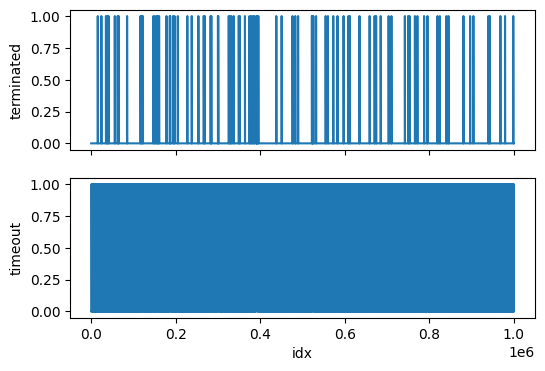

In [23]:
# plot terminate and timeout
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(terminated)
ax[1].plot(timeout)

ax[0].set_ylabel("terminated")
ax[1].set_ylabel("timeout")
ax[1].set_xlabel("idx")
plt.show()

In [46]:
# subsample terminal and non-terminal next_obs
np.random.seed(seed)

idx = np.arange(len(obs))
idx_terminal = idx[terminated == 1]
idx_nonterminal = idx[terminated == 0]
idx_timeout = idx[timeout == 1]
np.random.permutation(idx_terminal)

num_samples = 1000
idx_nonterminal = idx_nonterminal[:num_samples]
next_obs_nonterminal = next_obs[idx_nonterminal]
next_obs_terminal = next_obs[idx_terminal]
next_obs_trunc = next_obs[idx_timeout]

print("nonterminal sample size", next_obs_nonterminal.shape)
print("terminal sample size",  next_obs_terminal.shape)
print("timeout sample size",  next_obs_trunc.shape)

nonterminal sample size (1000, 11)
terminal sample size (89, 11)
truncated sample size (938, 11)


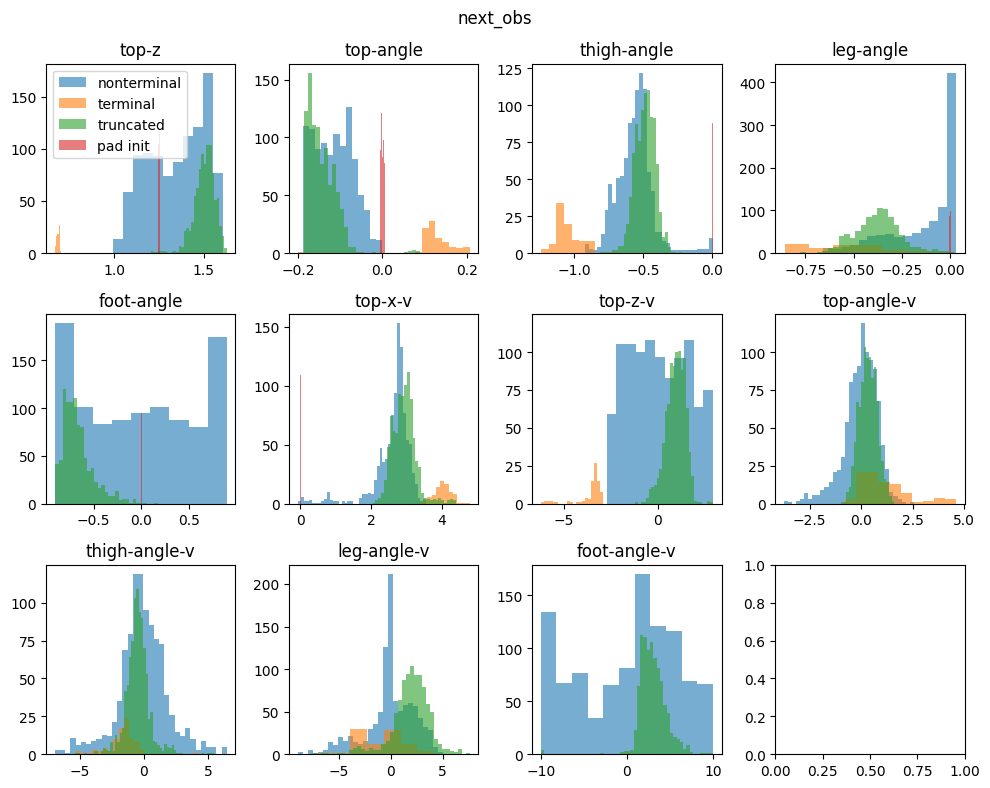

In [114]:
# plot next_obs histograms
fig, ax = plt.subplots(3, 4, figsize=(10, 8))
ax = ax.flat
for i in range(obs.shape[1]):
    ax[i].hist(next_obs_nonterminal[:, i], bins="fd", alpha=0.6, label="nonterminal")
    ax[i].hist(next_obs_terminal[:, i], bins="fd", alpha=0.6, label="terminal")
    ax[i].hist(next_obs_trunc[:, i], bins="fd", alpha=0.6, label="truncated")
    ax[i].hist(pad_dataset["obs"][0, :, i], bins="fd", alpha=0.6, label="init")
    ax[i].set_title(hopper_obs_names[i])

ax[0].legend()
plt.suptitle("next_obs")
plt.tight_layout()
plt.show()

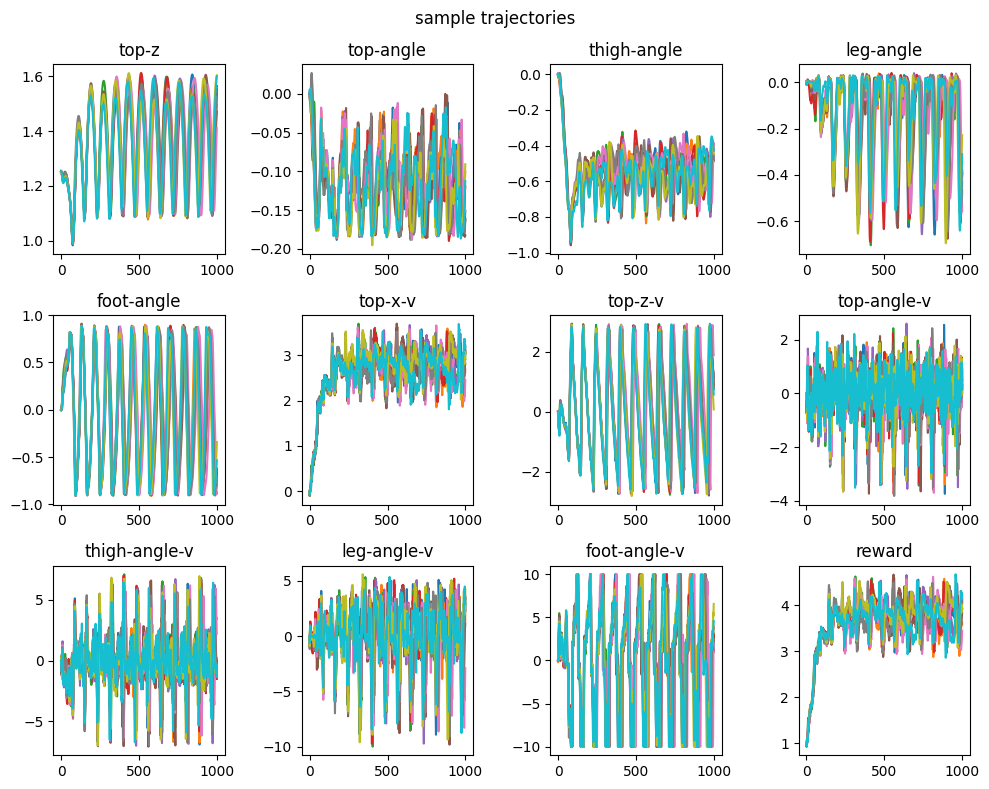

In [116]:
# plot a batch of trajectories
batch_size = 10
idx = np.arange(mask.shape[1])
np.random.permutation(idx)
idx = idx[:batch_size]

fig, ax = plt.subplots(3, 4, figsize=(10, 8))
ax = ax.flat
for i in range(obs.shape[1]):
    ax[i].plot(pad_dataset["obs"][:, idx, i])
    ax[i].set_title(hopper_obs_names[i])

ax[-1].plot(pad_dataset["rwd"][:, idx])
ax[-1].set_title("reward")
plt.suptitle("sample trajectories")
plt.tight_layout()
plt.show()